# (a)copy

In [3]:
import wave

# 讀取原始音訊檔案
with wave.open('Nello.wav', 'rb') as a_wave:
    params = a_wave.getparams()
    audio_frames = a_wave.readframes(a_wave.getnframes())

# 寫入新的音訊檔案
with wave.open('b_cpy.wav', 'wb') as b_wave:
    b_wave.setparams(params)
    b_wave.writeframes(audio_frames)


# (b)DFT and IDFT

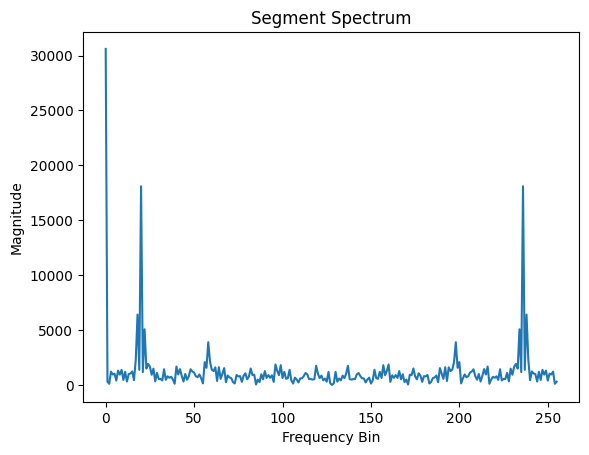

In [5]:
import wave
import numpy as np
import matplotlib.pyplot as plt

# 讀取音訊檔案
with wave.open('Nello.wav', 'rb') as a_wave:
    params = a_wave.getparams()
    n_frames = a_wave.getnframes()
    audio_frames = a_wave.readframes(n_frames)
    audio_data = np.frombuffer(audio_frames, dtype=np.uint8)
    audio_data = audio_data - 128  # 中心化處理

N = 256  # 分段長度

# 分段處理
segments = [audio_data[i:i+N] for i in range(0, len(audio_data), N)]
processed_segments = []

for idx, segment in enumerate(segments):
    if len(segment) < N:
        segment = np.pad(segment, (0, N - len(segment)), 'constant')

    # DFT
    spectrum = np.fft.fft(segment)

    # 頻譜展示（僅展示第一段）
    if idx == 0:
        magnitude = np.abs(spectrum)
        plt.figure()
        plt.plot(magnitude)
        plt.title('Segment Spectrum')
        plt.xlabel('Frequency Bin')
        plt.ylabel('Magnitude')
        plt.show()

    # IDFT
    recovered_segment = np.fft.ifft(spectrum)
    recovered_segment = np.real(recovered_segment)
    processed_segments.append(recovered_segment)

# 重組音訊數據
processed_audio = np.concatenate(processed_segments)
processed_audio = processed_audio + 128  # 轉回無符號
processed_audio = processed_audio.astype(np.uint8)

# 寫入新的音訊檔案
with wave.open('b_DFT_IDFT.wav', 'wb') as b_wave:
    b_wave.setparams(params)
    b_wave.writeframes(processed_audio.tobytes())


# (c)filter_original

In [11]:
N = 1024  # 分段長度
P = 300   # 低通濾波器截止頻率索引
Q = 20    # 高通濾波器截止頻率索引

# 分段處理
segments = [audio_data[i:i+N] for i in range(0, len(audio_data), N)]
processed_segments = []

for segment in segments:
    if len(segment) < N:
        segment = np.pad(segment, (0, N - len(segment)), 'constant')

    # DFT
    spectrum = np.fft.fft(segment)

    # 濾波器設計
    H = np.ones(N)
    # 低通濾波器
    H[P:N-P] = 0
    # 高通濾波器
    H[:Q] = 0
    H[N-Q:] = 0

    # 應用濾波器
    filtered_spectrum = spectrum * H

    # IDFT
    recovered_segment = np.fft.ifft(filtered_spectrum)
    recovered_segment = np.real(recovered_segment)
    processed_segments.append(recovered_segment)

# 重組音訊數據
processed_audio = np.concatenate(processed_segments)
processed_audio = processed_audio + 128  # 轉回無符號
processed_audio = np.clip(processed_audio, 0, 255)
processed_audio = processed_audio.astype(np.uint8)

# 寫入新的音訊檔案
with wave.open('b_filter.wav', 'wb') as b_wave:
    b_wave.setparams(params)
    b_wave.writeframes(processed_audio.tobytes())


# (d)filter_plus
增加了濾波器的設計使聲音能夠展現出來，不單單只有雜音。

In [ ]:
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows, firwin

# 讀取音訊檔案
with wave.open('Nello.wav', 'rb') as a_wave:
    params = a_wave.getparams()
    n_frames = a_wave.getnframes()
    audio_frames = a_wave.readframes(n_frames)
    audio_data = np.frombuffer(audio_frames, dtype=np.uint8)
    audio_data = audio_data - 128  # 中心化處理

N = 1024  # 分段長度
overlap = N // 2  # 50% 重疊
step = N - overlap
segments = [audio_data[i:i+N] for i in range(0, len(audio_data)-N, step)]

processed_audio = np.zeros(len(audio_data) + N)
window_correction = np.zeros(len(audio_data) + N)
window = windows.hann(N)  # 使用漢寧窗

# 濾波器設計
cutoff_freq = 3000  # 截止頻率（Hz）
fs = params.framerate  # 取樣率
numtaps = 101  # 濾波器階數
fir_coeff = firwin(numtaps, cutoff=cutoff_freq, fs=fs, pass_zero='lowpass')
#-------------
for i, segment in enumerate(segments):
    idx = i * step
    if len(segment) < N:
        segment = np.pad(segment, (0, N - len(segment)), 'constant')
    
    # 應用窗函數
    segment = segment * window

    # DFT
    spectrum = np.fft.fft(segment)

    # 頻率軸
    freqs = np.fft.fftfreq(N, d=1/fs)

    # 濾波器設計（平滑濾波器）
    H = np.zeros(N)
    H[np.abs(freqs) <= cutoff_freq] = 1

    # 應用濾波器
    filtered_spectrum = spectrum * H

    # IDFT
    recovered_segment = np.fft.ifft(filtered_spectrum)
    recovered_segment = np.real(recovered_segment)
    recovered_segment = recovered_segment * window  # 再次應用窗函數

    # 重疊加法
    processed_audio[idx:idx+N] += recovered_segment
    window_correction[idx:idx+N] += window**2

# 能量補償
processed_audio = processed_audio / (window_correction + 1e-10)  # 防止除以零

# 轉回無符號整數
processed_audio = processed_audio[:len(audio_data)]  # 修剪到原始長度
processed_audio = processed_audio + 128
processed_audio = np.clip(processed_audio, 0, 255)
processed_audio = processed_audio.astype(np.uint8)

# 寫入新的音訊檔案
with wave.open('b_filter2.wav', 'wb') as b_wave:
    b_wave.setparams(params)
    b_wave.writeframes(processed_audio.tobytes())


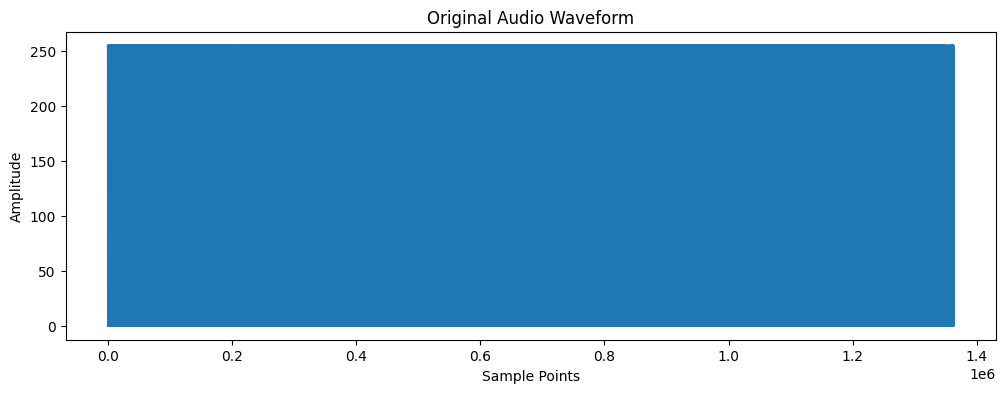

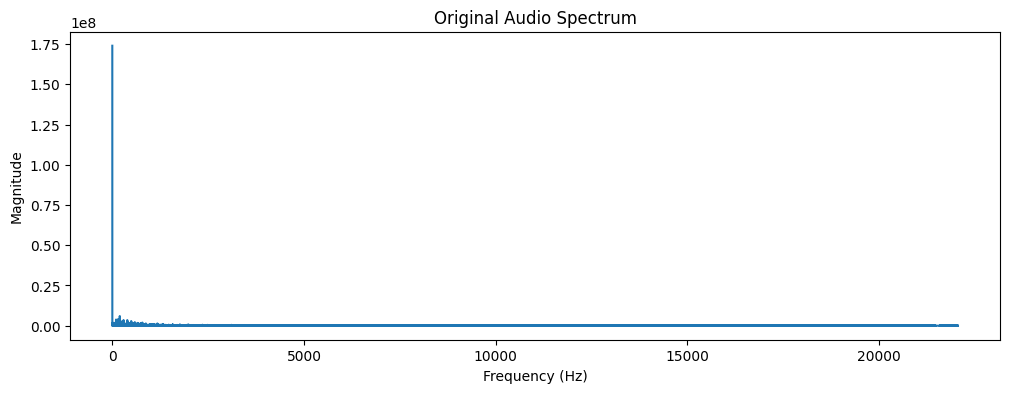

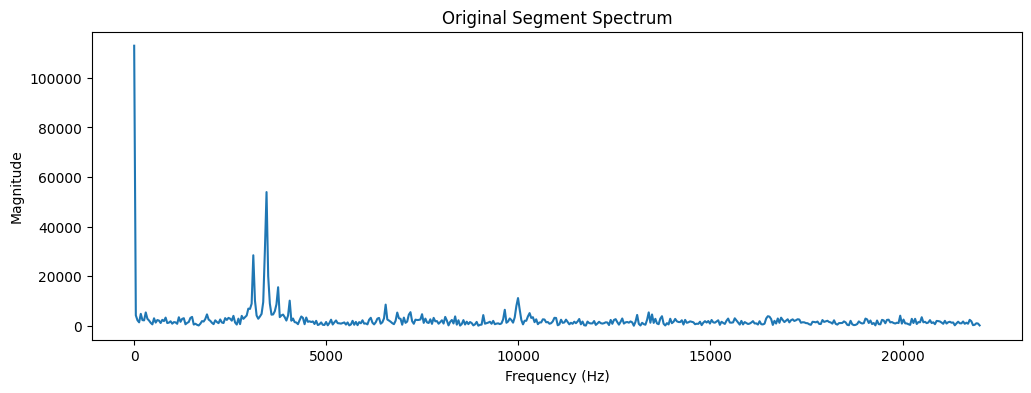

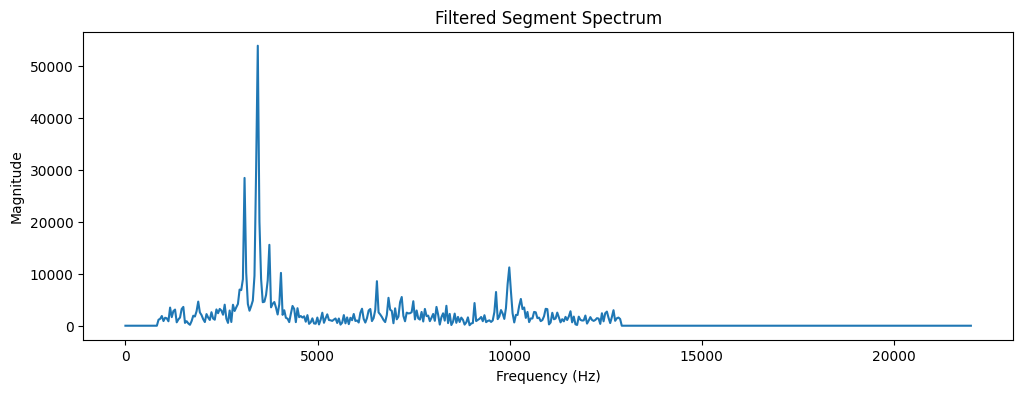

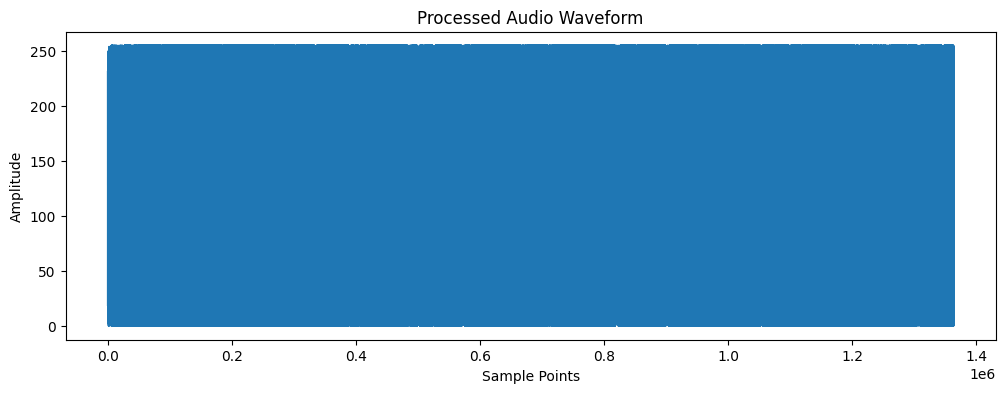

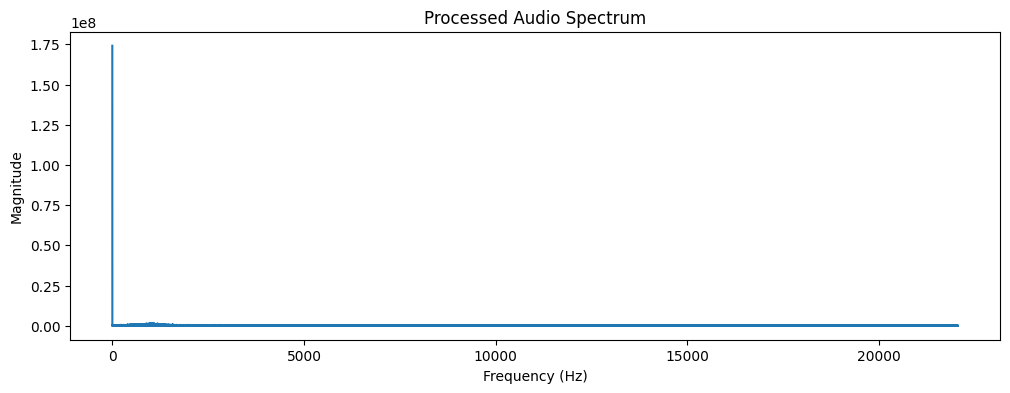

In [16]:
import wave
import numpy as np
import matplotlib.pyplot as plt

# Read audio file
with wave.open('Nello.wav', 'rb') as a_wave:
    params = a_wave.getparams()
    n_frames = a_wave.getnframes()
    audio_frames = a_wave.readframes(n_frames)
    audio_data = np.frombuffer(audio_frames, dtype=np.uint8)
    audio_data = audio_data - 128  # Centering

# Plot original audio waveform
plt.figure(figsize=(12, 4))
plt.plot(audio_data)
plt.title('Original Audio Waveform')
plt.xlabel('Sample Points')
plt.ylabel('Amplitude')
plt.show()

# Plot original audio spectrum
audio_spectrum = np.fft.fft(audio_data)
freqs = np.fft.fftfreq(len(audio_spectrum), d=1/params.framerate)
plt.figure(figsize=(12, 4))
plt.plot(freqs[:len(freqs)//2], np.abs(audio_spectrum)[:len(audio_spectrum)//2])
plt.title('Original Audio Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

# Segment processing
N = 1024  # Segment length
P = 300   # Low-pass filter cutoff index
Q = 20    # High-pass filter cutoff index

segments = [audio_data[i:i+N] for i in range(0, len(audio_data), N)]
processed_segments = []

for i, segment in enumerate(segments):
    if len(segment) < N:
        segment = np.pad(segment, (0, N - len(segment)), 'constant')

    # DFT
    spectrum = np.fft.fft(segment)

    # Plot original segment spectrum (only plot the first segment)
    if i == 0:
        freqs = np.fft.fftfreq(N, d=1/params.framerate)
        plt.figure(figsize=(12, 4))
        plt.plot(freqs[:N//2], np.abs(spectrum)[:N//2])
        plt.title('Original Segment Spectrum')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.show()

    # Filter design
    H = np.ones(N)
    # Low-pass filter
    H[P:N-P] = 0
    # High-pass filter
    H[:Q] = 0
    H[N-Q:] = 0

    # Apply filter
    filtered_spectrum = spectrum * H

    # Plot filtered segment spectrum (only plot the first segment)
    if i == 0:
        plt.figure(figsize=(12, 4))
        plt.plot(freqs[:N//2], np.abs(filtered_spectrum)[:N//2])
        plt.title('Filtered Segment Spectrum')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.show()

    # IDFT
    recovered_segment = np.fft.ifft(filtered_spectrum)
    recovered_segment = np.real(recovered_segment)
    processed_segments.append(recovered_segment)

# Reconstruct audio data
processed_audio = np.concatenate(processed_segments)
processed_audio = processed_audio + 128  # Convert back to unsigned
processed_audio = np.clip(processed_audio, 0, 255)
processed_audio = processed_audio.astype(np.uint8)

# Plot processed audio waveform
plt.figure(figsize=(12, 4))
plt.plot(processed_audio - 128)
plt.title('Processed Audio Waveform')
plt.xlabel('Sample Points')
plt.ylabel('Amplitude')
plt.show()

# Plot processed audio spectrum
processed_spectrum = np.fft.fft(processed_audio - 128)
freqs = np.fft.fftfreq(len(processed_spectrum), d=1/params.framerate)
plt.figure(figsize=(12, 4))
plt.plot(freqs[:len(freqs)//2], np.abs(processed_spectrum)[:len(processed_spectrum)//2])
plt.title('Processed Audio Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

# Write the new audio file
with wave.open('b_filter.wav', 'wb') as b_wave:
    b_wave.setparams(params)
    b_wave.writeframes(processed_audio.tobytes())
